In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.preprocessing import StandardScaler

In [2]:
# generate synthetic data
n_samples = 500
outliers_fraction = 0.05
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers

In [3]:
# generat inliers using a blob generator
blobs_params = dict(
    n_samples = n_inliers,
    n_features = 2,
    random_state = 0
)
data = make_blobs(
    centers=[[0, 0], [0, 0]],
    cluster_std=0.5,
    **blobs_params)[0]

In [4]:
# generate outliers data
rng = np.random.RandomState(42)
outliers = rng.uniform(low=-6, high=6, size=(n_outliers, 2))

In [6]:
# concatenate both inliers and outliers to create the final dataset
data = np.concatenate([data, outliers], axis = 0)

In [7]:
# scale the data
scaler = StandardScaler()
data = scaler.fit_transform(data)

In [8]:
# fit the model
isof = IsolationForest(contamination=outliers_fraction, random_state=42).fit(data)

In [9]:
y_pred = isof.predict(data)

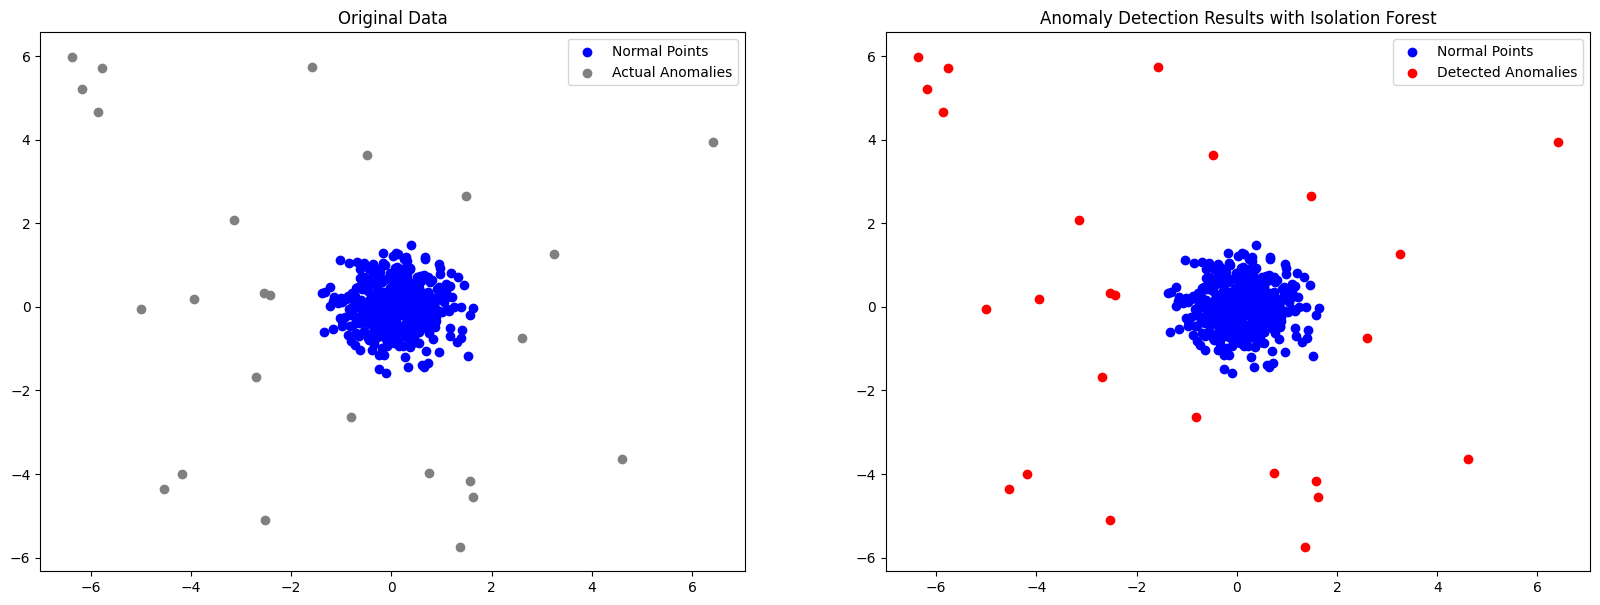

In [10]:
# Create a dataframe for easier data manipulation
df = pd.DataFrame(data, columns = ['x1', 'x2'])
df['anomaly'] = y_pred

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 7))

# Plot the normal points
normal_points = df[df['anomaly'] == 1]
# Plot the anomalies
anomalies = df[df['anomaly'] == -1]

# Plot original data
axs[0].scatter(df['x1'][:n_inliers], df['x2'][:n_inliers], color='b', label='Normal Points')
axs[0].scatter(df['x1'][n_inliers:], df['x2'][n_inliers:], color='grey', label='Actual Anomalies')
axs[0].set_title('Original Data')
axs[0].legend()

# Plot detected results
axs[1].scatter(normal_points['x1'], normal_points['x2'], color='b', label='Normal Points')
axs[1].scatter(anomalies['x1'], anomalies['x2'], color='r', label='Detected Anomalies')
axs[1].set_title('Anomaly Detection Results with Isolation Forest')
axs[1].legend()

plt.show()
